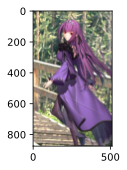

In [1]:
%matplotlib inline
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

d2l.set_figsize()
img = d2l.Image.open('./test.PNG')
d2l.plt.imshow(img)

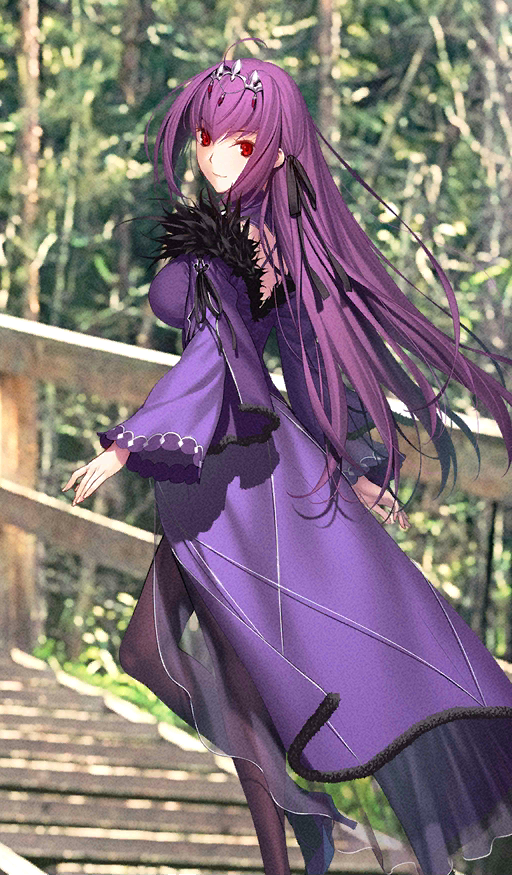

In [2]:
img

In [3]:
def apply(img, aug, num_rows=2, num_cols=4, scale=1.5):
    '''aug:method of augmentation, num_rows/num_cols:the number of augmented results'''
    Y = [aug(img) for _ in range(num_rows*num_cols)]
    d2l.show_images(Y, num_rows, num_cols, scale=scale)

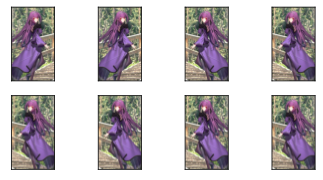

In [4]:
apply(img, torchvision.transforms.RandomHorizontalFlip())

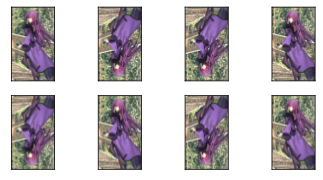

In [5]:
apply(img, torchvision.transforms.RandomVerticalFlip())

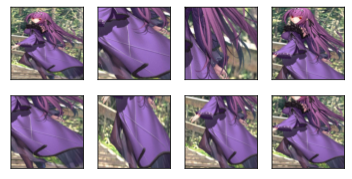

In [6]:
# crop scale% of img, change height/weight to ratio, scale to (200, 200)
shape_aug = torchvision.transforms.RandomResizedCrop((200,200), scale=(0.1,1), ratio=(0.5,2))

apply(img, shape_aug)

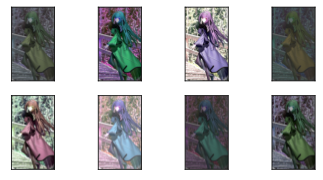

In [7]:
color_aug = torchvision.transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5)
apply(img, color_aug)

Mix various augmentation methods

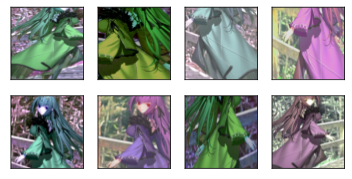

In [8]:
augs = torchvision.transforms.Compose([torchvision.transforms.RandomHorizontalFlip(), shape_aug, color_aug])
apply(img, augs)

### Train a net with augmented data CIFAR10

Files already downloaded and verified


array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

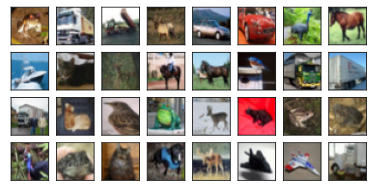

In [9]:
all_images = torchvision.datasets.CIFAR10(train=True, root = '../data', download=True) # a small img set of imagenet
d2l.show_images([all_images[i][0] for i in range(32)], 4, 8, scale=0.8)

In [10]:
train_augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor()
]) # we need convert the img to tensor

test_augs = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

In [11]:
def load_cifar10(is_train, augs, batch_size):
    dataset = torchvision.datasets.CIFAR10(root='../data/', train=is_train, transform=augs, download=True)
    # larger num_workers on img augmentation
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=is_train, num_workers=4)
    return dataloader

In [12]:
batch_size, devices, net = 256, d2l.try_all_gpus(), d2l.resnet18(10,3)
def init_weight(m):
    if type(m) in [nn.Linear, nn.Conv2d]:
        nn.init.xavier_uniform_(m.weight)
net.apply(init_weight)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (resnet_block1): Sequential(
    (0): Residual(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Residual(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (resnet_block2): Sequential(
   

In [13]:
def train_with_data_aug(train_augs, test_augs, net, lr=0.001):
    train_iter = load_cifar10(True, train_augs, batch_size)
    test_iter = load_cifar10(False, test_augs, batch_size)
    print("Data augmentation done!")
    loss = nn.CrossEntropyLoss(reduction='none')
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    d2l.train_ch13(net, train_iter, test_iter, loss, optimizer, 10, devices)

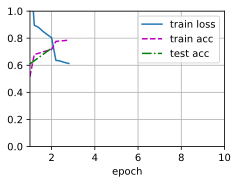

In [ ]:
train_with_data_aug(train_augs, test_augs, net)